In [19]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from ast import literal_eval
pd.set_option('display.max_colwidth', None)  
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from umap import UMAP

In [20]:
# Load the dataset
df = pd.read_csv('data/nvidia_articles.csv', converters={'content': literal_eval, 'stemmed_content': literal_eval, 'lemmatized_content': literal_eval})

# Use 'lemmatized_content' for topic modeling (ensure it's string data)
docs = [' '.join(doc) for doc in df['lemmatized_content']]


# Base Model - Tutorial

In [21]:
# Create the BERTopic model (DistilBERT embeddings are used by default)
bert_topic = BERTopic()

# Fit the model and transform the documents into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)

# Get information about the topics
topic_matrix = bert_topic.get_topic_info()

# Display topic matrix
print(topic_matrix)

# Get the c_tf_idf matrix from the model and convert to dense array
c_tf_idf = bert_topic.c_tf_idf_.toarray()

# Calculate coherence score, ignoring the outlier topic (-1)
coherence_scores = []
for topic_id in bert_topic.get_topics().keys():
    if topic_id == -1:  # Ignore outlier topic
        continue
    # Get the indices of the top 5 words in the topic's c_tf_idf values
    top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]
    # Calculate the mean c_tf_idf for these top words (coherence score for the topic)
    top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
    coherence_scores.append(np.mean(top_words_c_tf_idf))

# Calculate the average coherence score across all topics
average_coherence = np.mean(coherence_scores)

# Print the average coherence score
print(f"Average Topic Coherence Score: {average_coherence}")

    Topic  Count                                Name  \
0      -1   1149        -1_stock_year_company_market   
1       0    162      0_million_quarter_revenue_year   
2       1    137      1_amd_graphic_processor_radeon   
3       2     83    2_resistance_around_towards_roku   
4       3     79          3_driving_vehicle_car_self   
..    ...    ...                                 ...   
69     68     11          68_traded_seven_lowest_gmt   
70     69     11  69_softbank_fund_vision_investment   
71     70     11          70_traded_seven_lowest_gmt   
72     71     10  71_sma_beta_semiconductor_industry   
73     72     10    72_nasdaq_parent_midday_alphabet   

                                                                          Representation  \
0         [stock, year, company, market, nasdaq, zacks, earnings, growth, nvidia, share]   
1         [million, quarter, revenue, year, zacks, cent, company, consensus, rank, gaap]   
2                 [amd, graphic, processor, radeon,

A topic coherence score between 0.3 and 0.6 can be considered as "good"

- Too many documents in Topic -1: This may indicate that model isn’t able to classify a large portion of the dataset properly.
- Topics are too broad or too similar

What Does Topic -1 Mean?

Topic -1 represents outlier documents—those that the model could not confidently assign to any of the generated topics. 

# Iteration 1 - Filter Out Frequent Words

Filter out common words that appear across too many documents by setting max_df in the vectorizer.

The max_df value with the highest coherence score is 0.6777777777777778 with a coherence score of 0.11020997565572761


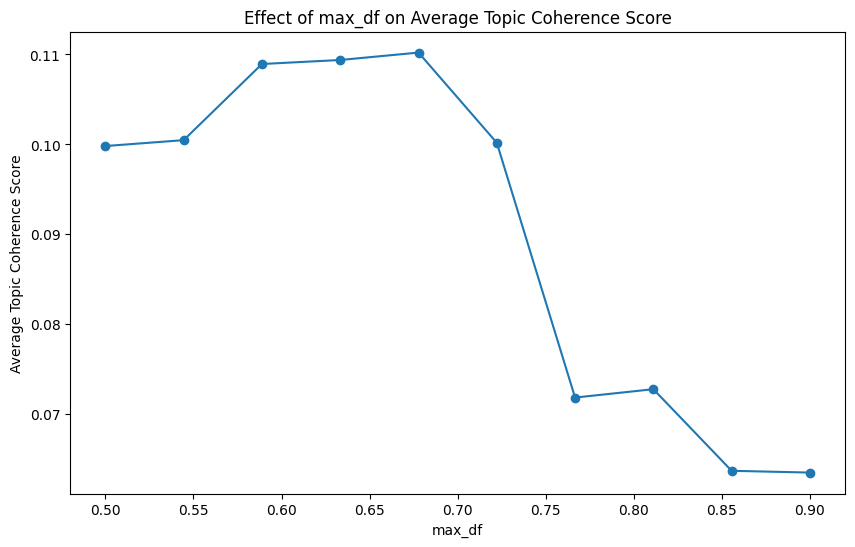

In [22]:
# Define a range of max_df values to test
max_df_values = np.linspace(0.5, 0.9, 10)
coherence_scores_list = []

for max_df in max_df_values:
    # Initialize vectorizer with the current max_df value
    vectorizer = CountVectorizer(max_df=max_df)
    
    # Initialize and fit BERTopic with the custom vectorizer
    bert_topic = BERTopic(vectorizer_model=vectorizer)
    topics, _ = bert_topic.fit_transform(docs)
    
    # Convert the c_tf_idf matrix to dense format
    c_tf_idf = bert_topic.c_tf_idf_.toarray()
    
    # Calculate coherence for each topic
    coherence_scores = []
    for topic_id in bert_topic.get_topics().keys():
        if topic_id == -1:  # Ignore outlier topic
            continue
        # Get the indices of the top 5 words in the topic's c_tf_idf values
        top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

        # Calculate the mean c_tf_idf for these top words
        top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
        coherence_scores.append(np.mean(top_words_c_tf_idf))
    
    # Store the average coherence score for the current max_df
    average_coherence = np.mean(coherence_scores)
    coherence_scores_list.append(average_coherence)
    
# Find the max_df value with the highest coherence score
best_max_df_index = np.argmax(coherence_scores_list)
best_max_df = max_df_values[best_max_df_index]
best_coherence_score = coherence_scores_list[best_max_df_index]

# Print the max_df value with the highest coherence score
print(f"The max_df value with the highest coherence score is {best_max_df} with a coherence score of {best_coherence_score}")

# Plot max_df values against average coherence scores
plt.figure(figsize=(10, 6))
plt.plot(max_df_values, coherence_scores_list, marker='o')
plt.title("Effect of max_df on Average Topic Coherence Score")
plt.xlabel("max_df")
plt.ylabel("Average Topic Coherence Score")
plt.show()

In [23]:
# Create a vectorizer with max_df to filter out very common words
vectorizer = CountVectorizer(max_df=best_max_df)  # Filter words appearing in more than 67% of documents
    
# Initialize and fit BERTopic with the custom vectorizer
bert_topic = BERTopic(vectorizer_model=vectorizer)
    
# Fit the model and transform the documents into topics
topics, _ = bert_topic.fit_transform(docs)

# Get information about the topics
topic_matrix = bert_topic.get_topic_info()

# Display topic matrix
print(topic_matrix)

# Convert the c_tf_idf matrix to dense format
c_tf_idf = bert_topic.c_tf_idf_.toarray()
    
# Calculate coherence for each topic
coherence_scores = []
for topic_id in bert_topic.get_topics().keys():
    if topic_id == -1:  # Ignore outlier topic
        continue
    # Get the indices of the top 5 words in the topic's c_tf_idf values
    top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

    # Calculate the mean c_tf_idf for these top words
    top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
    coherence_scores.append(np.mean(top_words_c_tf_idf))
    
# Store the average coherence score for the current max_df
average_coherence = np.mean(coherence_scores)

# Print the average coherence score
print(f"Average Topic Coherence Score: {average_coherence}")

    Topic  Count                             Name  \
0      -1   1097      -1_percent_etf_eps_dividend   
1       0    147       0_ai_pc_processor_learning   
2       1    145           1_cent_gaap_netapp_non   
3       2    131   2_graphic_radeon_gpu_processor   
4       3     84  3_vehicle_self_autonomous_tesla   
..    ...    ...                              ...   
68     67     11             67_seven_lowest_gmt_   
69     68     11  68_midday_parent_alphabet_googl   
70     69     11             69_seven_lowest_gmt_   
71     70     10         70_sma_beta_arm_emerging   
72     71     10       71_tsmc_samsung_taiwan_apr   

                                                                            Representation  \
0                    [percent, etf, eps, dividend, ratio, segment, cent, dow, risk, chart]   
1                [ai, pc, processor, learning, machine, robotics, computing, ibm, cpu, hp]   
2                     [cent, gaap, netapp, non, surprise, margin, esp, pegged, ne

# Iteration 2 - Try Different Bert Models

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from bertopic import BERTopic
import matplotlib.pyplot as plt

# Define a list of different BERT models to experiment with
bert_models = [
    "all-MiniLM-L6-v2",
    "paraphrase-MiniLM-L12-v2",
    "distilbert-base-nli-mean-tokens",
    "xlm-r-bert-base-nli-stsb-mean-tokens"
]

# Define the max_df value
max_df = best_max_df  # Filter words appearing in more than 67% of documents

# Store coherence scores for each model
model_coherence_scores = []

# Iterate over each BERT model
for model_name in bert_models:
    print(f"\nUsing BERT model: {model_name}")

    # Create a vectorizer with the specified max_df
    vectorizer = CountVectorizer(max_df=max_df)
    
    # Initialize BERTopic with the custom vectorizer and embedding model
    bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=model_name)
    
    # Fit the model and transform the documents into topics
    topics, _ = bert_topic.fit_transform(docs)

    # Get information about the topics
    topic_matrix = bert_topic.get_topic_info()

    # Display topic matrix
    print(f"\nTopic matrix for model {model_name}:")
    print(topic_matrix)

    # Convert the c_tf_idf matrix to dense format
    c_tf_idf = bert_topic.c_tf_idf_.toarray()
    
    # Calculate coherence for each topic, ignoring the outlier topic (-1)
    coherence_scores = []
    for topic_id in bert_topic.get_topics().keys():
        if topic_id == -1:  # Ignore outlier topic
            continue
        # Get the indices of the top 5 words in the topic's c_tf_idf values
        top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

        # Calculate the mean c_tf_idf for these top words
        top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
        coherence_scores.append(np.mean(top_words_c_tf_idf))
    
    # Calculate and store the average coherence score for the current model
    average_coherence = np.mean(coherence_scores)
    model_coherence_scores.append((model_name, average_coherence))
    
    # Print the average coherence score for the current model
    print(f"Average Topic Coherence Score for model {model_name}: {average_coherence}")

# Summarize coherence scores for all models
print("\nCoherence Scores for Different BERT Models:")
for model_name, coherence_score in model_coherence_scores:
    print(f"{model_name}: {coherence_score}")


Using BERT model: all-MiniLM-L6-v2

Topic matrix for model all-MiniLM-L6-v2:
    Topic  Count                             Name  \
0      -1   1132          -1_percent_etf_dow_fund   
1       0    171           0_cent_gaap_netapp_esp   
2       1    132     1_radeon_gpu_processor_ryzen   
3       2     97        2_dow_fed_trump_president   
4       3     86  3_resistance_towards_roku_break   
..    ...    ...                              ...   
66     65     13  65_baidu_apollo_autonomous_self   
67     66     11             66_seven_lowest_gmt_   
68     67     11           67_ndls_ttd_loser_nwsa   
69     68     10         68_boeing_gm_gainer_talk   
70     69     10  69_google_alphabet_android_java   

                                                                                Representation  \
0                       [percent, etf, dow, fund, trump, eps, fed, economic, ratio, president]   
1              [cent, gaap, netapp, esp, pegged, gross, expense, approximately, bps, adju

The distilbert-base-nli-mean-tokens has the highest coherence score and is therefore the preferred model

In [35]:
# Create a vectorizer with max_df to filter out very common words
vectorizer = CountVectorizer(max_df=best_max_df)  # Filter words appearing in more than 67% of documents
    
# Initialize a SentenceTransformer model for embeddings
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')  

# Initialize BERTopic model with custom embeddings
bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=embedding_model)
    
# Fit the model and transform the documents into topics
topics, _ = bert_topic.fit_transform(docs)

# Get information about the topics
topic_matrix = bert_topic.get_topic_info()

# Display topic matrix
print(topic_matrix)

# Convert the c_tf_idf matrix to dense format
c_tf_idf = bert_topic.c_tf_idf_.toarray()
    
# Calculate coherence for each topic
coherence_scores = []
for topic_id in bert_topic.get_topics().keys():
    if topic_id == -1:  # Ignore outlier topic
        continue
    # Get the indices of the top 5 words in the topic's c_tf_idf values
    top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

    # Calculate the mean c_tf_idf for these top words
    top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
    coherence_scores.append(np.mean(top_words_c_tf_idf))
    
# Store the average coherence score for the current max_df
average_coherence = np.mean(coherence_scores)

# Print the average coherence score
print(f"Average Topic Coherence Score: {average_coherence}")

    Topic  Count                              Name  \
0      -1     30         -1_analyst_also_zacks_new   
1       0   2983    0_year_company_market_earnings   
2       1    101  1_investment_zacks_research_blog   
3       2     69    2_podcast_tracey_value_episode   
4       3     29       3_traded_lowest_gmt_tuesday   
5       4     24        4_inc_close_performer_nyse   
6       5     23      5_analyst_zacks_per_research   
7       6     22        6_inc_close_performer_nyse   
8       7     21              7_traded_lowest_gmt_   
9       8     19     8_traded_lowest_gmt_wednesday   
10      9     18              9_traded_lowest_gmt_   
11     10     18  10_qualcomm_patent_commission_eu   
12     11     17   11_rallied_soared_climbed_italy   
13     12     16      12_traded_lowest_gmt_tuesday   
14     13     16       13_inc_close_performer_nyse   
15     14     15        14_lunch_dave_ryan_episode   
16     15     13             15_traded_lowest_gmt_   
17     16     12            

In [36]:
bert_topic.visualize_topics()  # Intertopic distance map

In [37]:
bert_topic.visualize_heatmap()  # Topic similarity heatmap

# Iteration 3: Dimensionality Reduction before Topic Modeling

In [28]:
# Step 1: Set up the vectorizer to filter out very common words
vectorizer = CountVectorizer(max_df=best_max_df)  # Filter words appearing in more than 67% of documents

# Step 2: Initialize a SentenceTransformer model for embeddings
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Step 3: Set up UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine')  # Adjust n_neighbors and n_components as needed

# Step 4: Initialize BERTopic with the custom vectorizer, embedding model, and UMAP model
bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=embedding_model, umap_model=umap_model)

# Step 5: Fit the model and transform the documents into topics
topics, _ = bert_topic.fit_transform(docs)

# Step 6: Get information about the topics
topic_matrix = bert_topic.get_topic_info()

# Display topic matrix
print("Topic Matrix:")
print(topic_matrix)

# Step 7: Convert the c_tf_idf matrix to dense format
c_tf_idf = bert_topic.c_tf_idf_.toarray()

# Step 8: Calculate coherence for each topic
coherence_scores = []
for topic_id in bert_topic.get_topics().keys():
    if topic_id == -1:  # Ignore outlier topic
        continue
    # Get the indices of the top 5 words in the topic's c_tf_idf values
    top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

    # Calculate the mean c_tf_idf for these top words
    top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
    coherence_scores.append(np.mean(top_words_c_tf_idf))

# Calculate and print the average coherence score for the current max_df
average_coherence = np.mean(coherence_scores)
print(f"Average Topic Coherence Score: {average_coherence}")

Topic Matrix:
    Topic  Count                              Name  \
0      -1     10                     -1_tuesday___   
1       0   3130       0_year_company_zacks_market   
2       1     99  1_zacks_investment_research_blog   
3       2     24        2_inc_close_performer_nyse   
4       3     23            3_thursday_wednesday__   
5       4     22        4_inc_close_performer_nyse   
6       5     21                       5_friday___   
7       6     19                       6_monday___   
8       7     19                    7_wednesday___   
9       8     18                       8_monday___   
10      9     17    9_rallied_soared_climbed_italy   
11     10     16       10_inc_close_performer_nyse   
12     11     16                     11_tuesday___   
13     12     12                      12_friday___   
14     13     11                    13_thursday___   

                                                                                   Representation  \
0                   

# Visualisations

In [29]:
bert_topic.visualize_topics()  # Intertopic distance map

In [30]:
bert_topic.visualize_heatmap()  # Topic similarity heatmap

# Uitprobeersel Remove Common Words

Remove highly frequent, generic terms like “percent”, “index”, “stock”, etc., from the corpus. This will prevent these terms from dominating the topics.

In [15]:
# Step 1: Use CountVectorizer to get the word frequency
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs)  # Fit and transform the documents

# Step 2: Get the total word counts across all documents
word_counts = X.toarray().sum(axis=0)

# Step 3: Map the words to their frequencies
vocab = vectorizer.get_feature_names_out()  # Get the vocabulary
word_freq = dict(zip(vocab, word_counts))  # Create a dictionary of word:frequency

# Step 4: Sort the words by frequency
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

# Convert the dictionary to a Pandas DataFrame for easy viewing
word_freq_df = pd.DataFrame(list(sorted_word_freq.items()), columns=['Word', 'Frequency'])

# Display the top 20 most frequent words
print(word_freq_df.head(50))

             Word  Frequency
0            year      16105
1         company      15462
2           stock      15460
3          nasdaq      14891
4           zacks      11544
5          market      10551
6        earnings       9938
7          nvidia       8950
8         quarter       8722
9           share       8235
10         growth       7356
11        revenue       7211
12        billion       6329
13           also       6258
14           nyse       6231
15     technology       5559
16       estimate       5456
17            new       5101
18       investor       5035
19        million       4813
20           rank       4803
21           last       4775
22            inc       4601
23           week       4498
24       expected       4301
25            day       4143
26          price       4128
27         report       4080
28           nvda       3961
29            buy       3937
30            one       3904
31     investment       3893
32           time       3883
33          tr

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Assuming 'docs' contains the list of documents

# Step 1: Use CountVectorizer to get word counts for each document
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs)

# Step 2: Calculate the number of documents each word appears in
word_counts_per_doc = (X > 0).sum(axis=0)  # Count the number of documents each word appears in
word_counts_per_doc = np.array(word_counts_per_doc)[0]

# Step 3: Get the total number of documents
num_docs = len(docs)

# Step 4: Calculate document frequency (percentage of documents containing each word)
vocab = vectorizer.get_feature_names_out()  # Get the words (vocabulary)
doc_freq = word_counts_per_doc / num_docs  # Document frequency of each word

# Step 5: Create a DataFrame with words and their document frequencies
word_doc_freq_df = pd.DataFrame({'Word': vocab, 'Doc Frequency (%)': doc_freq * 100})

# Step 6: Filter words that appear in more than 50% of documents
stop_words_= word_doc_freq_df[word_doc_freq_df['Doc Frequency (%)'] > 60]['Word'].tolist()

# Step 7: Display the stop words list
print(stop_words_)
print(f"Length of the stopword list: {len(stop_words_)}")

['also', 'company', 'market', 'nasdaq', 'new', 'nvda', 'nvidia', 'nyse', 'share', 'stock', 'year']
Length of the stopword list: 11


In [17]:
# Create a vectorizer with max_df to filter out very common words
vectorizer = CountVectorizer(stop_words=stop_words_, max_df=best_max_df)

# Initialize a SentenceTransformer model for embeddings
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')  

# Initialize BERTopic model with custom embeddings
bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=embedding_model)
# Fit the model and transform the documents into topics
topics, _ = bert_topic.fit_transform(docs)

# Get information about the topics
topic_matrix = bert_topic.get_topic_info()

# Display topic matrix
print(topic_matrix)

# Convert the c_tf_idf matrix to dense format
c_tf_idf = bert_topic.c_tf_idf_.toarray()
    
# Calculate coherence for each topic
coherence_scores = []
for topic_id in bert_topic.get_topics().keys():
    if topic_id == -1:  # Ignore outlier topic
        continue
    # Get the indices of the top 5 words in the topic's c_tf_idf values
    top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

    # Calculate the mean c_tf_idf for these top words
    top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
    coherence_scores.append(np.mean(top_words_c_tf_idf))
    
# Store the average coherence score for the current max_df
average_coherence = np.mean(coherence_scores)

# Print the average coherence score
print(f"Average Topic Coherence Score: {average_coherence}")

    Topic  Count                                    Name  \
0      -1   1452             -1_percent_cent_oil_economy   
1       0    157                 0_dow_percent_yield_oil   
2       1    116  1_bitcoin_gpus_currency_cryptocurrency   
3       2    103          2_resistance_fed_dma_inflation   
4       3     96            3_radeon_card_hp_application   
..    ...    ...                                     ...   
65     64     12             64_score_style_premium_gaap   
66     65     12              65_traded_seven_lowest_gmt   
67     66     11             66_ratio_peg_metric_audited   
68     67     11  67_mutual_conversational_lottery_azure   
69     68     11              68_traded_seven_lowest_gmt   

                                                                                          Representation  \
0                             [percent, cent, oil, economy, dow, operating, fed, chart, yield, qualcomm]   
1                             [dow, percent, yield, oil, sessio

# Andere Probeersels

Geeft allemaal niet veel verbetering

In [18]:
# Create a vectorizer with max_df to filter out very common words
vectorizer = CountVectorizer(max_df=best_max_df)
# vectorizer = CountVectorizer(max_df=0.6333333333333333, min_df=20)
# Initialize a SentenceTransformer model for embeddings
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')  

# Initialize BERTopic model with custom embeddings
bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=embedding_model)
# bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=embedding_model, nr_topics="auto", min_topic_size=20, top_n_words=15)
# bert_topic = BERTopic(vectorizer_model=vectorizer, embedding_model=embedding_model, nr_topics="auto")

# Fit the model and transform the documents into topics
topics, _ = bert_topic.fit_transform(docs)

# Get information about the topics
topic_matrix = bert_topic.get_topic_info()

# Display topic matrix
print(topic_matrix)

# Convert the c_tf_idf matrix to dense format
c_tf_idf = bert_topic.c_tf_idf_.toarray()
    
# Calculate coherence for each topic
coherence_scores = []
for topic_id in bert_topic.get_topics().keys():
    if topic_id == -1:  # Ignore outlier topic
        continue
    # Get the indices of the top 5 words in the topic's c_tf_idf values
    top_word_indices = np.argsort(c_tf_idf[topic_id])[::-1][:5]

    # Calculate the mean c_tf_idf for these top words
    top_words_c_tf_idf = c_tf_idf[topic_id][top_word_indices]
    coherence_scores.append(np.mean(top_words_c_tf_idf))
    
# Store the average coherence score for the current max_df
average_coherence = np.mean(coherence_scores)

# Print the average coherence score
print(f"Average Topic Coherence Score: {average_coherence}")

    Topic  Count                              Name  \
0      -1     16   -1_like_gold_podcast_technology   
1       0   3030    0_year_company_market_earnings   
2       1    101  1_investment_zacks_research_blog   
3       2     44      2_tracey_value_podcast_zacks   
4       3     29                 3_gmt_wednesday__   
5       4     26                   4_gmt_tuesday__   
6       5     24        5_inc_close_performer_nyse   
7       6     23      6_analyst_zacks_per_research   
8       7     22        7_inc_close_performer_nyse   
9       8     21                          8_gmt___   
10      9     19                    9_gmt_monday__   
11     10     18                   10_gmt_monday__   
12     11     17   11_rallied_soared_climbed_italy   
13     12     16       12_inc_close_performer_nyse   
14     13     15         13_book_podcast_new_human   
15     14     13                 14_gmt_thursday__   
16     15     12                         15_gmt___   
17     16     11            